# LIBRARY

In [ ]:
from keras.layers import Dense, Input
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense, Dropout, Embedding, Activation
from tensorflow.python.keras.callbacks import EarlyStopping
import tensorflow.python.keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from numpy import mean
from numpy import absolute
from numpy import sqrt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# DATASET

In [2]:
data = pd.read_csv('./data/final_data_new.csv')

In [3]:
data.head(3)

,size,width,length,room,area,ward,toilet,living size,floor,house type,street,price
0,44.0,3.5,12.0,2.0,102,9466.0,2.0,78.04,1.0,3.0,1161,3750000000
1,65.0,3.8,17.0,6.0,111,9328.0,6.0,238.00,3.0,1.0,1040,18500000000
2,44.8,3.2,14.0,2.0,104,9256.0,2.0,44.80,1.0,3.0,2195,890000000


Hàm kiểm tra số lượng phần tử có giá dự đoán chênh lệch với giá thực lớn hơn 1 tỷ

In [4]:
one_billion = 1000000000

def find_prediction_error_value(actual, predict):
  error = []
  negative_integer = []
  for i in range(len(predict)):
    if predict[i] < 0:
      negative_integer.append(actual.index[i])
    if abs(predict[i] - actual.iloc[i]) > 1:
      error.append(actual.index[i])
  return error, negative_integer

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

# K-FOLD CROSS VALIDATION

In [5]:
cv = KFold(n_splits=20, random_state=1, shuffle=True)

# NORMALIZE
Chia tỷ lệ dữ liệu trong khoảng từ -1 đến 1

In [6]:
# data["price"] = np.log(data["price"])
# 1 tỉ
data["price"] = data["price"]/one_billion
X = data.drop("price", axis=1)
y = data["price"]
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(X)
X = pd.DataFrame(columns=X.columns, data=feature_minmax_transform_data)
X.head()

,size,width,length,room,area,ward,toilet,living size,floor,house type,street
0,0.172566,0.30,0.333333,0.142857,0.250000,0.510246,0.142857,0.193083,0.00,0.666667,0.294222
1,0.265487,0.36,0.492063,0.714286,0.625000,0.227459,0.714286,0.593985,0.50,0.000000,0.263558
2,0.176106,0.24,0.396825,0.142857,0.333333,0.079918,0.142857,0.109774,0.00,0.666667,0.556260
3,0.199115,0.48,0.288889,0.285714,0.708333,0.204918,0.142857,0.247820,0.25,0.666667,0.242271
4,0.103982,0.20,0.253968,0.142857,0.583333,0.106557,0.142857,0.140351,0.25,0.666667,0.567410


# TRAIN TEST SPLIT

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 8)

In [8]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (39800, 11)
y_train shape: (39800,)
X_test shape: (17689, 11)
y_test shape: (17689,)
X_val shape: (13267, 11)
y_val shape: (13267,)


In [9]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_vl_t = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# MODEL

In [10]:
labels_kfold = ['NN','LSTM', 'Linear', 'Ridge', 'Lasso', 'Polynomial', 'Bayesian Linear']
labels = ['Linear', 'Ridge', 'Lasso', 'Polynomial', 'Bayesian Linear']
compa_n_mse = []
compa_n_mae = []
compa_n_rmse = []
compa_n_r2 = []
compa_k_mse = []
compa_k_mae = []
compa_k_rmse = []
compa_k_mape = []
compa_k_r2 = []

## NN

### Model structure

In [11]:
K.clear_session()
model_nn = Sequential()
model_nn.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model_nn.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model_nn.add(Dense(1, activation='linear'))

model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


### MSE

In [ ]:
model_nn.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
156/156 [==============================] - 4s 4ms/step - loss: 15.2791 - accuracy: 0.0016 - val_loss: 8.1403 - val_accuracy: 9.7987e-04
Epoch 2/400
156/156 [==============================] - 0s 3ms/step - loss: 7.3534 - accuracy: 0.0016 - val_loss: 6.9891 - val_accuracy: 9.7987e-04
Epoch 3/400
156/156 [==============================] - 1s 4ms/step - loss: 6.9046 - accuracy: 0.0016 - val_loss: 6.7799 - val_accuracy: 9.7987e-04
Epoch 4/400
156/156 [==============================] - 0s 3ms/step - loss: 6.7966 - accuracy: 0.0016 - val_loss: 6.7066 - val_accuracy: 9.7987e-04
Epoch 5/400
156/156 [==============================] - 0s 3ms/step - loss: 6.7459 - accuracy: 0.0016 - val_loss: 6.6543 - val_accuracy: 9.7987e-04
Epoch 6/400
156/156 [==============================] - 0s 3ms/step - loss: 6.6907 - accuracy: 0.0016 - val_loss: 6.6015 - val_accuracy: 9.7987e-04
Epoch 7/400
156/156 [==============================] - 0s 3ms/step - loss: 6.6426 - accuracy: 0.0016 - val_loss: 6.54

#### Loss graph

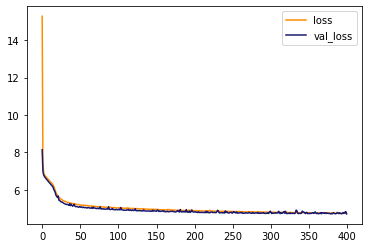

In [ ]:
loss_nn_df = pd.DataFrame(losses_nn.history)
loss_nn_df.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_nn_mse = model_nn.evaluate(X_test, y_test, batch_size=1)
y_pred_nn = model_nn.predict(X_test)

17689/17689 [==============================] - 35s 2ms/step - loss: 4.7554 - accuracy: 0.0017


In [ ]:
compa_k_mse.append(score_nn_mse[0])

In [ ]:
print('mse: %f'%score_nn_mse[0])

mse: 4.755429


In [ ]:
print(f"predicted response:\n{y_pred_nn[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.45367527e+09]
 [4.81455946e+09]
 [3.67042184e+09]
 [4.29453087e+09]
 [5.40828514e+09]
 [1.87843537e+09]
 [5.55209398e+09]
 [9.48513508e+09]
 [2.50603509e+09]
 [7.08725023e+09]]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_nn)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  9
Percent correct prediction:  49.34139860930522


### MAE

In [12]:
model_nn.compile(optimizer='adam',loss='mean_absolute_error',metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn_2 = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
156/156 [==============================] - 4s 4ms/step - loss: 3.1881 - accuracy: 0.0013 - val_loss: 2.1251 - val_accuracy: 9.7987e-04
Epoch 2/400
156/156 [==============================] - 1s 3ms/step - loss: 1.9637 - accuracy: 0.0016 - val_loss: 1.9036 - val_accuracy: 9.7987e-04
Epoch 3/400
156/156 [==============================] - 0s 3ms/step - loss: 1.8899 - accuracy: 0.0016 - val_loss: 1.8671 - val_accuracy: 9.7987e-04
Epoch 4/400
156/156 [==============================] - 0s 3ms/step - loss: 1.8612 - accuracy: 0.0016 - val_loss: 1.8422 - val_accuracy: 9.7987e-04
Epoch 5/400
156/156 [==============================] - 1s 3ms/step - loss: 1.8339 - accuracy: 0.0016 - val_loss: 1.8121 - val_accuracy: 9.7987e-04
Epoch 6/400
156/156 [==============================] - 0s 3ms/step - loss: 1.8088 - accuracy: 0.0016 - val_loss: 1.7898 - val_accuracy: 9.7987e-04
Epoch 7/400
156/156 [==============================] - 1s 3ms/step - loss: 1.7868 - accuracy: 0.0016 - val_loss: 1.768

#### Loss graph

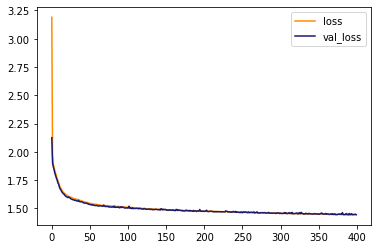

In [13]:
loss_df_nn_2 = pd.DataFrame(losses_nn_2.history)
loss_df_nn_2.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [14]:
score_mae = model_nn.evaluate(X_test, y_test, batch_size=1)
y_pred_nn_2 = model_nn.predict(X_test)

17689/17689 [==============================] - 32s 2ms/step - loss: 1.4630 - accuracy: 0.0017


In [15]:
compa_k_mae.append(score_mae[0])

In [16]:
print('mae: %f'%score_mae[0])

mae: 1.462952


In [17]:
print(f"predicted response:\n{y_pred_nn_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.53901052e+09]
 [5.18655396e+09]
 [4.14155102e+09]
 [3.86145926e+09]
 [5.21858025e+09]
 [1.79606736e+09]
 [2.63878179e+09]
 [8.79618740e+09]
 [2.71757388e+09]
 [6.29370594e+09]]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [18]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_nn_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  4
Percent correct prediction:  52.51286110011871


### RMSE

In [19]:
model_nn.compile(optimizer='adam',loss=root_mean_squared_error,metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn_3 = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
156/156 [==============================] - 1s 4ms/step - loss: 2.1633 - accuracy: 0.0016 - val_loss: 2.1568 - val_accuracy: 9.7987e-04
Epoch 2/400
156/156 [==============================] - 0s 3ms/step - loss: 2.1621 - accuracy: 0.0016 - val_loss: 2.1498 - val_accuracy: 9.7987e-04
Epoch 3/400
156/156 [==============================] - 0s 3ms/step - loss: 2.1587 - accuracy: 0.0016 - val_loss: 2.1479 - val_accuracy: 9.7987e-04
Epoch 4/400
156/156 [==============================] - 0s 3ms/step - loss: 2.1573 - accuracy: 0.0015 - val_loss: 2.1468 - val_accuracy: 9.7987e-04
Epoch 5/400
156/156 [==============================] - 0s 3ms/step - loss: 2.1532 - accuracy: 0.0016 - val_loss: 2.1481 - val_accuracy: 9.7987e-04
Epoch 6/400
156/156 [==============================] - 0s 3ms/step - loss: 2.1536 - accuracy: 0.0016 - val_loss: 2.1523 - val_accuracy: 9.7987e-04
Epoch 7/400
156/156 [==============================] - 0s 3ms/step - loss: 2.1533 - accuracy: 0.0016 - val_loss: 2.151

#### Loss graph

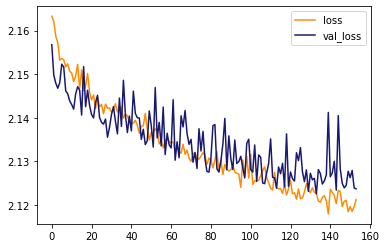

In [20]:
loss_df_nn_3 = pd.DataFrame(losses_nn_3.history)
loss_df_nn_3.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [21]:
score_rmse = model_nn.evaluate(X_test, y_test, batch_size=1)
y_pred_nn_3 = model_nn.predict(X_test)

17689/17689 [==============================] - 33s 2ms/step - loss: 1.4652 - accuracy: 0.0017


In [22]:
compa_k_rmse.append(score_rmse[0])

In [23]:
print('rmse: %f'%score_rmse[0])

rmse: 1.465166


In [24]:
print(f"predicted response:\n{y_pred_nn_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.38683701e+09]
 [4.96741581e+09]
 [3.81245923e+09]
 [4.13958263e+09]
 [5.64705801e+09]
 [1.67414284e+09]
 [3.21052742e+09]
 [8.72254944e+09]
 [2.80360103e+09]
 [6.07680225e+09]]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [25]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_nn_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  7
Percent correct prediction:  51.037367855729556


### R2

In [26]:
model_nn.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_nn_5 = model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
156/156 [==============================] - 1s 4ms/step - loss: 4.5217 - accuracy: 0.0015 - val_loss: 4.5884 - val_accuracy: 9.7987e-04
Epoch 2/400
156/156 [==============================] - 0s 3ms/step - loss: 4.5268 - accuracy: 0.0015 - val_loss: 4.5327 - val_accuracy: 9.7987e-04
Epoch 3/400
156/156 [==============================] - 1s 3ms/step - loss: 4.5119 - accuracy: 0.0015 - val_loss: 4.5516 - val_accuracy: 9.7987e-04
Epoch 4/400
156/156 [==============================] - 0s 3ms/step - loss: 4.5132 - accuracy: 0.0016 - val_loss: 4.5249 - val_accuracy: 9.7987e-04
Epoch 5/400
156/156 [==============================] - 0s 3ms/step - loss: 4.5220 - accuracy: 0.0015 - val_loss: 4.5374 - val_accuracy: 9.7987e-04
Epoch 6/400
156/156 [==============================] - 1s 3ms/step - loss: 4.5156 - accuracy: 0.0015 - val_loss: 4.5428 - val_accuracy: 9.7987e-04
Epoch 7/400
156/156 [==============================] - 0s 3ms/step - loss: 4.5103 - accuracy: 0.0016 - val_loss: 4.547

#### r2 values

In [27]:
y_pred_nn_5 = model_nn.predict(X_test)
score_r2 = r2_score(y_test, y_pred_nn_5)

In [28]:
compa_k_r2.append(score_r2)

In [29]:
print('r2: %f'%score_r2)

r2: 0.656208


## LSTM

### Model structure

In [30]:
K.clear_session()
model_1 = Sequential()

model_1.add(LSTM(128, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(64, activation='tanh', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(32, activation='relu', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(16, activation='relu'))
model_1.add(Dropout(0.3))

model_1.add(Dense(1))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            71680     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3

### MSE

In [ ]:
model_1.compile(loss='mean_squared_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])
# losses = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=1)

Epoch 1/400
156/156 [==============================] - 15s 40ms/step - loss: 24.2965 - val_loss: 8.7199
Epoch 2/400
156/156 [==============================] - 5s 34ms/step - loss: 10.6638 - val_loss: 7.2970
Epoch 3/400
156/156 [==============================] - 5s 33ms/step - loss: 9.7405 - val_loss: 6.8088
Epoch 4/400
156/156 [==============================] - 5s 35ms/step - loss: 9.4878 - val_loss: 6.6102
Epoch 5/400
156/156 [==============================] - 5s 34ms/step - loss: 9.1728 - val_loss: 6.6415
Epoch 6/400
156/156 [==============================] - 6s 36ms/step - loss: 8.9789 - val_loss: 6.5850
Epoch 7/400
156/156 [==============================] - 5s 34ms/step - loss: 8.9537 - val_loss: 6.4818
Epoch 8/400
156/156 [==============================] - 5s 34ms/step - loss: 8.7719 - val_loss: 6.4431
Epoch 9/400
156/156 [==============================] - 5s 33ms/step - loss: 8.7294 - val_loss: 6.4063
Epoch 10/400
156/156 [==============================] - 5s 33ms/step - loss: 8.

#### Loss graph

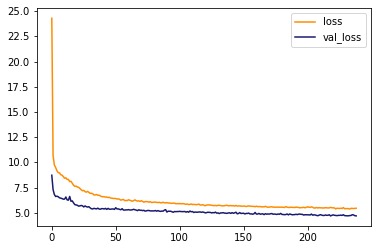

In [ ]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mse = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_1 = model_1.predict(X_tst_t)

17689/17689 [==============================] - 63s 4ms/step - loss: 4.6999


In [ ]:
compa_k_mse.append(score_mse)

In [ ]:
print('mse: %f'%score_mse)

mse: 4.699904


In [ ]:
print(f"predicted response:\n{y_pred_1[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.50413704e+09]
 [4.18075371e+09]
 [3.55991507e+09]
 [5.05196238e+09]
 [5.60997009e+09]
 [2.48557377e+09]
 [2.83750081e+09]
 [8.85498047e+09]
 [3.24903297e+09]
 [6.01594448e+09]]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_1)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  46.39041212052688


### MAE

In [31]:
model_1.compile(loss='mean_absolute_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_2 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
156/156 [==============================] - 15s 42ms/step - loss: 3.7294 - val_loss: 2.1144
Epoch 2/400
156/156 [==============================] - 5s 32ms/step - loss: 2.4488 - val_loss: 1.9589
Epoch 3/400
156/156 [==============================] - 5s 31ms/step - loss: 2.3144 - val_loss: 1.8964
Epoch 4/400
156/156 [==============================] - 5s 31ms/step - loss: 2.2670 - val_loss: 1.9006
Epoch 5/400
156/156 [==============================] - 5s 31ms/step - loss: 2.2260 - val_loss: 1.8485
Epoch 6/400
156/156 [==============================] - 5s 31ms/step - loss: 2.2035 - val_loss: 1.7913
Epoch 7/400
156/156 [==============================] - 5s 31ms/step - loss: 2.1646 - val_loss: 1.7675
Epoch 8/400
156/156 [==============================] - 5s 31ms/step - loss: 2.1274 - val_loss: 1.7395
Epoch 9/400
156/156 [==============================] - 5s 31ms/step - loss: 2.0808 - val_loss: 1.7583
Epoch 10/400
156/156 [==============================] - 5s 31ms/step - loss: 2.05

#### Loss graph

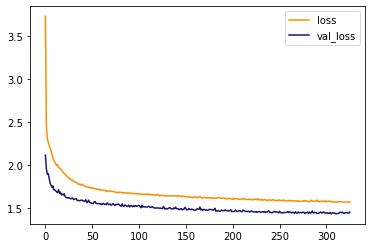

In [32]:
loss_df_2 = pd.DataFrame(losses_2.history)
loss_df_2.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [33]:
score_mae = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_2 = model_1.predict(X_tst_t)

17689/17689 [==============================] - 62s 3ms/step - loss: 1.4528


In [34]:
compa_k_mae.append(score_mae)

In [35]:
print('mae: %f'%score_mae)

mae: 1.452792


In [36]:
print(f"predicted response:\n{y_pred_lstm_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.80373478e+09]
 [4.54706240e+09]
 [3.33018732e+09]
 [5.08678532e+09]
 [5.64867115e+09]
 [1.68441224e+09]
 [1.92426205e+09]
 [7.54811764e+09]
 [3.61994123e+09]
 [6.55356932e+09]]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [37]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  54.18056419243597


### RMSE

In [38]:
model_1.compile(loss=root_mean_squared_error, optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_3 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
156/156 [==============================] - 13s 38ms/step - loss: 2.3189 - val_loss: 2.1502
Epoch 2/400
156/156 [==============================] - 5s 32ms/step - loss: 2.2971 - val_loss: 2.1527
Epoch 3/400
156/156 [==============================] - 5s 32ms/step - loss: 2.3109 - val_loss: 2.1405
Epoch 4/400
156/156 [==============================] - 5s 32ms/step - loss: 2.3046 - val_loss: 2.1480
Epoch 5/400
156/156 [==============================] - 5s 32ms/step - loss: 2.3121 - val_loss: 2.1493
Epoch 6/400
156/156 [==============================] - 5s 31ms/step - loss: 2.3116 - val_loss: 2.1453
Epoch 7/400
156/156 [==============================] - 5s 31ms/step - loss: 2.3065 - val_loss: 2.1523
Epoch 8/400
156/156 [==============================] - 5s 32ms/step - loss: 2.2943 - val_loss: 2.1439
Epoch 9/400
156/156 [==============================] - 5s 31ms/step - loss: 2.2902 - val_loss: 2.1396
Epoch 10/400
156/156 [==============================] - 7s 43ms/step - loss: 2.30

#### Loss graph

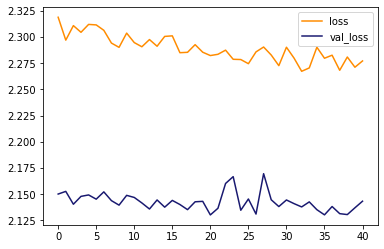

In [39]:
loss_df_3 = pd.DataFrame(losses_3.history)
loss_df_3.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [40]:
score_rmse = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_3 = model_1.predict(X_tst_t)

17689/17689 [==============================] - 61s 3ms/step - loss: 1.4747


In [41]:
compa_k_rmse.append(score_rmse)

In [42]:
print('rmse: %f'%score_rmse)

rmse: 1.474714


In [43]:
print(f"predicted response:\n{y_pred_lstm_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.92996693e+09]
 [4.59288502e+09]
 [3.99176311e+09]
 [5.46823788e+09]
 [5.86041307e+09]
 [1.74761152e+09]
 [2.52634168e+09]
 [8.13328457e+09]
 [3.61300135e+09]
 [6.91611242e+09]]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [44]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  50.91865000847985


### R2

In [45]:
model_1.compile(loss='mean_squared_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_5 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
156/156 [==============================] - 13s 36ms/step - loss: 5.2221 - val_loss: 4.5978
Epoch 2/400
156/156 [==============================] - 5s 31ms/step - loss: 5.2313 - val_loss: 4.5966
Epoch 3/400
156/156 [==============================] - 5s 31ms/step - loss: 5.1630 - val_loss: 4.5744
Epoch 4/400
156/156 [==============================] - 5s 31ms/step - loss: 5.2027 - val_loss: 4.6523
Epoch 5/400
156/156 [==============================] - 5s 30ms/step - loss: 5.2321 - val_loss: 4.6093
Epoch 6/400
156/156 [==============================] - 5s 31ms/step - loss: 5.1897 - val_loss: 4.5525
Epoch 7/400
156/156 [==============================] - 5s 30ms/step - loss: 5.1557 - val_loss: 4.6113
Epoch 8/400
156/156 [==============================] - 5s 32ms/step - loss: 5.1654 - val_loss: 4.6271
Epoch 9/400
156/156 [==============================] - 5s 30ms/step - loss: 5.2036 - val_loss: 4.5648
Epoch 10/400
156/156 [==============================] - 5s 31ms/step - loss: 5.17

#### r2 values

In [46]:
y_pred_lstm_5 = model_1.predict(X_tst_t)
score_r2 = r2_score(y_test, y_pred_lstm_5)

In [47]:
compa_k_r2.append(score_r2)

In [48]:
print('r2: %f'%score_r2)

r2: 0.659878


## Linear regression

In [ ]:
model_2 = LinearRegression()

### K-Fold

In [ ]:
scores_2_mse = mean(absolute(cross_val_score(model_2, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_2_mae = mean(absolute(cross_val_score(model_2, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_2_rmse = sqrt(mean(absolute(scores_2_mse)))
scores_2_r2 = mean(absolute(cross_val_score(model_2, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_2.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_2 = model_2.predict(X_test)
# Sai số huấn luyện của mô hình trên tập train
print(model_2.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_2.coef_)
print(model_2.intercept_)

0.4900927613952716
[ 0.89433076  1.63730362  6.80140122  1.00714889 -2.15790796 -2.71670225
  1.77076106  2.13030625  3.46237255 -1.82436249  0.0355535 ]
2.213403646598363


In [ ]:
print(f"predicted response:\n{y_pred_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.79548073e+09 4.61437297e+09 2.90548324e+09 7.63308716e+09
 6.94901681e+09 2.18265163e+09 6.69628635e+09 9.57021866e+09
 3.41403365e+09 8.12017079e+09]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_2))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_2))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_2)))
compa_n_r2.append(r2_score(y_test, y_pred_2))
compa_k_mse.append(scores_2_mse)
compa_k_mae.append(scores_2_mae)
compa_k_rmse.append(scores_2_rmse)
compa_k_r2.append(scores_2_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_2)}")
print(f"mse (K-fold):\n{scores_2_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_2)}")
print(f"mae (K-fold):\n{scores_2_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_2))}")
print(f"rmse (K-fold):\n{scores_2_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_2)}")
print(f"r2 (K-fold):\n{scores_2_r2}")

mse:
6.806054259537825
mse (K-fold):
6.817649736779241
mae:
1.900672552354137
mae (K-fold):
1.9048015095678104
rmse:
2.6088415550849047
rmse (K-fold):
2.6110629515159607
r2:
0.4903667294796241
r2 (K-fold):
0.48954279296153896


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  97
Percent correct prediction:  37.441347730227825


## Ridge regression

In [ ]:
model_3 = Ridge(alpha = 0.3,  tol = 0.003, solver ='auto', random_state = 42)

### K-Fold

In [ ]:
scores_3_mse = mean(absolute(cross_val_score(model_3, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_3_mae = mean(absolute(cross_val_score(model_3, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_3_rmse = sqrt(mean(absolute(scores_3_mse)))
scores_3_r2 = mean(absolute(cross_val_score(model_3, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
# training model with alpha = 0.5

model_3.fit(X_train, y_train)

y_pred_3 = model_3.predict(X_test)

# Sai số huấn luyện của mô hình trên tập train
print(model_3.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_3.coef_)
print(model_3.intercept_)

0.49009263302660666
[ 0.95090402  1.62086636  6.76377572  1.00850722 -2.15734613 -2.71653473
  1.77073931  2.1307404   3.46188934 -1.82449487  0.03555395]
2.2212881193782286


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_3))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_3))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_3)))
compa_n_r2.append(r2_score(y_test, y_pred_3))
compa_k_mse.append(scores_3_mse)
compa_k_mae.append(scores_3_mae)
compa_k_rmse.append(scores_3_rmse)
compa_k_r2.append(scores_3_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_3)}")
print(f"mse (K-fold):\n{scores_3_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_3)}")
print(f"mae (K-fold):\n{scores_3_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_3))}")
print(f"rmse (K-fold):\n{scores_3_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_3)}")
print(f"r2 (K-fold):\n{scores_3_r2}")

mse:
6.805970834798459
mse (K-fold):
6.817645555995009
mae:
1.9006203274217373
mae (K-fold):
1.9047788999486808
rmse:
2.6088255661884445
rmse (K-fold):
2.6110621509253678
r2:
0.4903729762741903
r2 (K-fold):
0.48954310202999973


In [ ]:
print(f"predicted response:\n{y_pred_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.79538789e+09 4.61367397e+09 2.90527630e+09 7.63335584e+09
 6.94868409e+09 2.18231680e+09 6.69637487e+09 9.56927547e+09
 3.41358075e+09 8.12220169e+09]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  97
Percent correct prediction:  37.441347730227825


## Lasso regression

In [ ]:
model_4 = Lasso(alpha=0.3)

### K-Fold

In [ ]:
scores_4_mse = mean(absolute(cross_val_score(model_4, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_4_mae = mean(absolute(cross_val_score(model_4, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_4_rmse = sqrt(mean(absolute(scores_4_mse)))
scores_4_r2 = mean(absolute(cross_val_score(model_4, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_4.fit(X_train, y_train)

y_pred_4 = model_4.predict(X_test)

# Sai số huấn luyện của mô hình trên tập train
print(model_4.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_4.coef_)
print(model_4.intercept_)

0.14017009850480389
[ 0.          0.          0.          0.         -0.         -0.
  0.          0.          2.29520526 -0.14329933  0.        ]
4.8030098813881


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_4))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_4))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_4)))
compa_n_r2.append(r2_score(y_test, y_pred_4))
compa_k_mse.append(scores_4_mse)
compa_k_mae.append(scores_4_mae)
compa_k_rmse.append(scores_4_rmse)
compa_k_r2.append(scores_4_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_4)}")
print(f"mse (K-fold):\n{scores_4_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_4)}")
print(f"mae (K-fold):\n{scores_4_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_4))}")
print(f"rmse (K-fold):\n{scores_4_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_4)}")
print(f"r2 (K-fold):\n{scores_4_r2}")

mse:
11.47719377143946
mse (K-fold):
11.49654226548328
mae:
2.550988446215927
mae (K-fold):
2.558256812434336
rmse:
3.3878007278232083
rmse (K-fold):
3.3906551380940053
r2:
0.14059459782620443
r2 (K-fold):
0.13959889506531364


In [ ]:
print(f"predicted response:\n{y_pred_4[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.42888094e+09 5.28127831e+09 4.70747699e+09 5.37681120e+09
 6.42888094e+09 4.70747699e+09 5.37681120e+09 6.42888094e+09
 5.28127831e+09 5.28127831e+09]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_4)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  25.563909774436087


## Polynomial regression

In [ ]:
model_5 = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])

### K-Fold

In [ ]:
scores_5_mse = mean(absolute(cross_val_score(model_5, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_5_mae = mean(absolute(cross_val_score(model_5, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_5_rmse = sqrt(mean(absolute(scores_5_mse)))
scores_5_r2 = mean(absolute(cross_val_score(model_5, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_5.fit(X_train, y_train)
y_pred_5 = model_5.predict(X_test)
# Sai số huấn luyện của mô hình trên tập train
print(model_5.score(X_train, y_train))

0.6237382288714923


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_5))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_5))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_5)))
compa_n_r2.append(r2_score(y_test, y_pred_5))
compa_k_mse.append(scores_5_mse)
compa_k_mae.append(scores_5_mae)
compa_k_rmse.append(scores_5_rmse)
compa_k_r2.append(scores_5_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_5)}")
print(f"mse (K-fold):\n{scores_5_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_5)}")
print(f"mae (K-fold):\n{scores_5_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_5))}")
print(f"rmse (K-fold):\n{scores_5_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_5)}")
print(f"r2 (K-fold):\n{scores_5_r2}")

mse:
5.122107251770336
mse (K-fold):
5.119194523226961
mae:
1.5834692910454207
mae (K-fold):
1.5804472733790615
rmse:
2.2632072931506597
rmse (K-fold):
2.2625637058935957
r2:
0.6164596738238297
r2 (K-fold):
0.61665283131591


In [ ]:
print(f"predicted response:\n{y_pred_5[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[5.81116872e+09 4.56751698e+09 4.14773991e+09 4.95590368e+09
 3.92400931e+09 2.14594527e+09 5.72706267e+09 8.53072216e+09
 3.52870433e+09 6.05765737e+09]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_5)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  10
Percent correct prediction:  47.142291819775004


## Bayesian linear regression

In [ ]:
model_6 = BayesianRidge()

### K-Fold

In [ ]:
scores_6_mse = mean(absolute(cross_val_score(model_6, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_6_mae = mean(absolute(cross_val_score(model_6, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_6_rmse = sqrt(mean(absolute(scores_6_mse)))
scores_6_r2 = mean(absolute(cross_val_score(model_6, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_6.fit(X_train, y_train)
y_pred_6 = model_6.predict(X_test)
# Sai số huấn luyện của mô hình trên tập train
print(model_6.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_6.coef_)
print(model_6.intercept_)

0.49009173294472896
[ 1.05386044  1.59092784  6.69500098  1.01107475 -2.15626087 -2.7161685
  1.77068682  2.13161945  3.46092719 -1.8247444   0.03555893]
2.235690141542817


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_6))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_6))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_6)))
compa_n_r2.append(r2_score(y_test, y_pred_6))
compa_k_mse.append(scores_6_mse)
compa_k_mae.append(scores_6_mae)
compa_k_rmse.append(scores_6_rmse)
compa_k_r2.append(scores_6_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_6)}")
print(f"mse (K-fold):\n{scores_6_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_6)}")
print(f"mae (K-fold):\n{scores_6_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_6))}")
print(f"rmse (K-fold):\n{scores_6_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_6)}")
print(f"r2 (K-fold):\n{scores_6_r2}")

mse:
6.805827429821462
mse (K-fold):
6.817641769831987
mae:
1.9005249091660705
mae (K-fold):
1.9047352387858283
rmse:
2.6087980814584832
rmse (K-fold):
2.611061425901732
r2:
0.4903837143530607
r2 (K-fold):
0.48954338323825797


In [ ]:
print(f"predicted response:\n{y_pred_6[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.79527101e+09 4.61241204e+09 2.90492752e+09 7.63387077e+09
 6.94804848e+09 2.18173140e+09 6.69653180e+09 9.56749096e+09
 3.41277882e+09 8.12593260e+09]
actual:
22453    6.600000e+09
68000    5.500000e+09
24488    1.680000e+09
6208     4.150000e+09
69780    7.090000e+09
43825    2.200000e+09
1208     1.500000e+09
52345    8.600000e+09
63577    4.150000e+09
19916    7.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_6)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  97
Percent correct prediction:  37.441347730227825


# COMPARISION

## Normal

### MSE

In [ ]:
print(compa_n_mse)

[6.806054259537825, 6.805970834798459, 11.47719377143946, 5.122107251770336, 6.805827429821462]


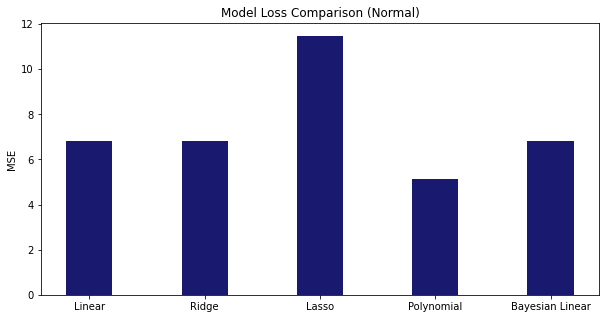

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_mse, width = 0.4, color = 'midnightblue')

plt.ylabel('MSE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### MAE

In [ ]:
print(compa_n_mae)

[1.900672552354137, 1.9006203274217373, 2.550988446215927, 1.5834692910454207, 1.9005249091660705]


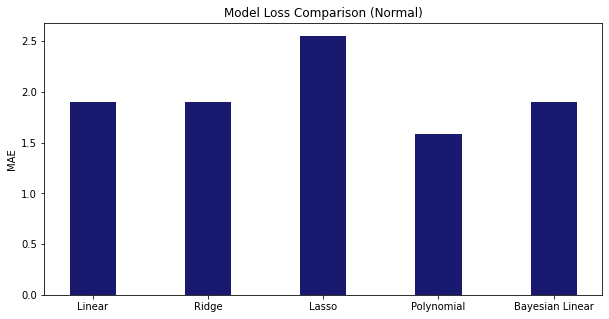

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_mae, width = 0.4, color = 'midnightblue')

plt.ylabel('MAE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### RMSE

In [ ]:
print(compa_n_rmse)

[2.6088415550849047, 2.6088255661884445, 3.3878007278232083, 2.2632072931506597, 2.6087980814584832]


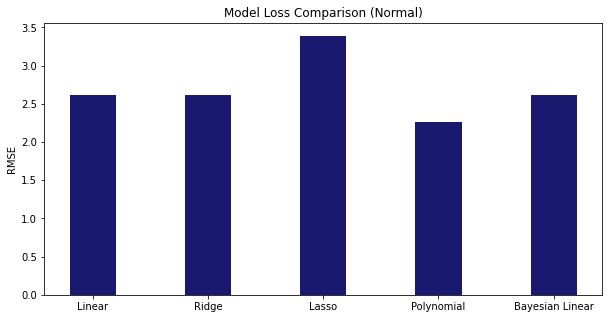

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_rmse, width = 0.4, color = 'midnightblue')

plt.ylabel('RMSE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### R2

In [ ]:
print(compa_n_r2)

[0.4903667294796241, 0.4903729762741903, 0.14059459782620443, 0.6164596738238297, 0.4903837143530607]


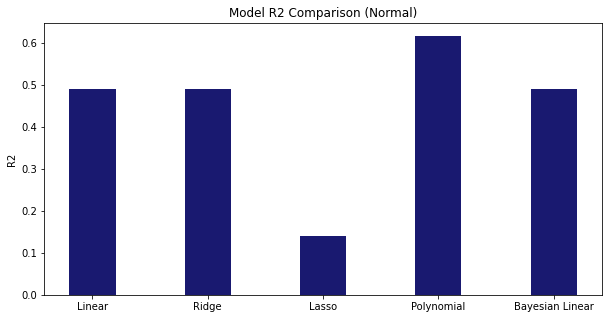

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_r2, width = 0.4, color = 'midnightblue')

plt.ylabel('R2')
plt.title('Model R2 Comparison (Normal)')
plt.show()

## K-Fold

### MSE

In [ ]:
print(compa_k_mse)

[4.755429, 4.699904, 6.817649736779241, 6.817645555995009, 11.49654226548328, 5.119194523226961, 6.817641769831987]


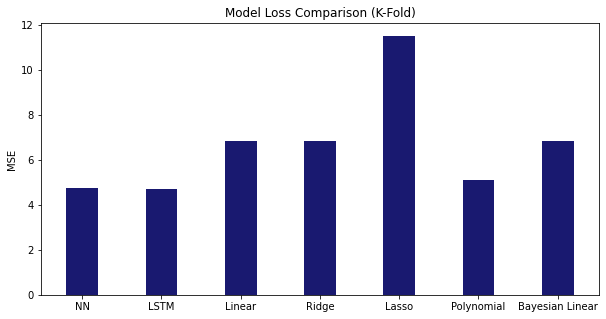

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_mse, width = 0.4, color = 'midnightblue')

plt.ylabel('MSE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### MAE

In [50]:
print(compa_k_mae)

[1.4629520177841187, 1.4527918100357056, 1.9048015095678104, 1.9047788999486808, 2.558256812434336, 1.5804472733790615, 1.9047352387858283]


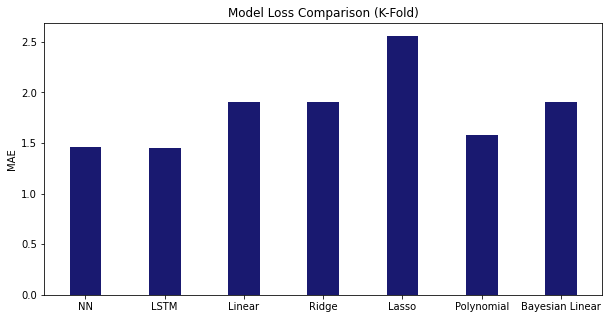

In [51]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_mae, width = 0.4, color = 'midnightblue')

plt.ylabel('MAE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### RMSE

In [53]:
print(compa_k_rmse)

[1.4651657342910767, 1.474713683128357, 2.6110629515159607, 2.6110621509253678, 3.3906551380940053, 2.2625637058935957, 2.611061425901732]


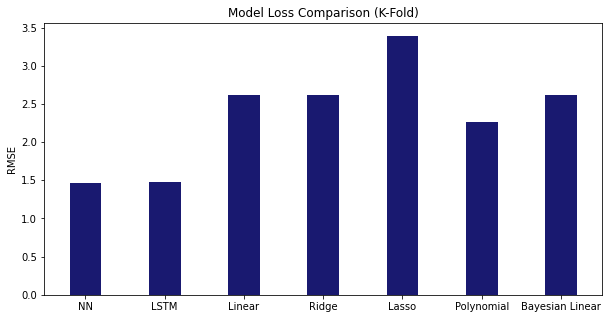

In [54]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_rmse, width = 0.4, color = 'midnightblue')

plt.ylabel('RMSE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### R2

In [56]:
print(compa_k_r2)

[0.6562077749581856, 0.6598782018484676, 0.48954279296153896, 0.48954310202999973, 0.13959889506531364, 0.61665283131591, 0.48954338323825797]


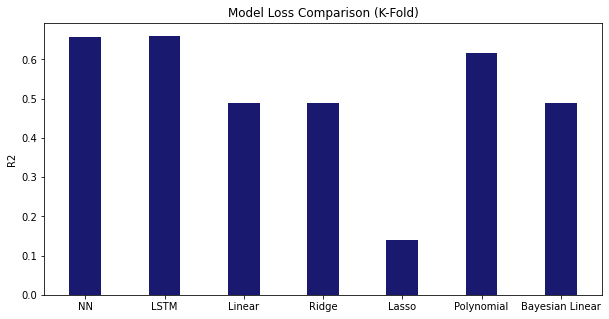

In [57]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_r2, width = 0.4, color = 'midnightblue')

plt.ylabel('R2')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()